In [3]:
import pandas as pd
re_test_df = pd.read_csv('re_build_test_question_cut_9keys.csv')

Ground_Truth,e0,e1,e2,e3,e4,e5,e6,e7,e8,source_question



In [2]:
import pandas as pd

re_test_true_df = pd.read_csv('true_env_test.csv')
re_test_true_df

,Ground_Truth,e0,e1,e2,e3,e4,e5,e6,e7,e8,source_question
0,在哪里报名呢？,什么时候确认报名？,什么时候截止报名？,可以给朋友报名吗？,报名成功后有什么通知吗,活动售罄了还可以报名吗,什么时候可以确定报名成功,什么时候可以确定报名成功,篱苑书屋的活动还可以报名吗？,为什么我不能报名了呢，提示活动无法报名？,去哪报名？
1,篱苑书屋的活动还可以报名吗？,为什么我不能报名了呢，提示活动无法报名？,什么时候确认报名？,什么时候截止报名？,可以给朋友报名吗？,在哪里报名呢？,报名成功后有什么通知吗,报名成功后有什么通知吗,活动售罄了还可以报名吗,什么时候可以确定报名成功,篱苑还能报名吗


In [3]:
import pandas as pd
import jieba
import jieba.posseg as pseg
from keras.preprocessing.text import Tokenizer
import time

# tokenizer = Tokenizer()
def add_space(cut):
    return " ".join(cut)

# key_list = ['source_question','target_question']
key_list = ['source_question','Ground_Truth',
               'e0','e1','e2','e3','e4','e5','e6','e7','e8']#test list
df = re_test_true_df

start = time.time()
# a =df.equivalent0.apply(jieba.cut)
for keys in key_list:
    a =df[keys].apply(jieba.cut)
    df[keys] =a.apply(add_space)
    print(time.time()-start)
#     tokenizer.fit_on_texts(df[keys])
#     a =df[keys].apply(jieba.cut)
#     a =a.apply(add_space)
#     tokenizer.fit_on_texts(a)    
df.to_csv('true_env_test_cut.csv',index=None)

Using TensorFlow backend.
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.215 seconds.
Prefix dict has been built succesfully.


1.2187929153442383
1.219785213470459
1.220762014389038
1.221705675125122
1.222508430480957
1.2241849899291992
1.2251689434051514
1.2260158061981201
1.2270171642303467
1.2280282974243164
1.2290992736816406


In [1]:
import tensorflow as tf

class test_reader(object):
    def __init__(self):
        self.train_file_path  = "re_build_test_question_cut_9keys.csv"
        self.dict_file_path = "./question_tokenizer.dict"
        self._CSV_COLUMN_DEFAULTS = [[''],[''],[''],[''],[''],
                                     [''],[''],[''],[''],[''],['']]
        self._CSV_CLOLUMNS = ['Ground_Truth','e0','e1','e2','e3','e4',
                              'e5','e6','e7','e8','source_question']
        self.word_dict = {}
        with open(self.dict_file_path, 'r') as f:
            for l in f.readlines():
                word, idx = l.split(' ')[0], l.split(' ')[1]
                self.word_dict[word] = float(idx)
        print("word_dict size:", len(self.word_dict))
        self.UNK_ID = self.word_dict['<unk>']
        self.length = 10
        
        kv_initializer = tf.contrib.lookup.TextFileInitializer(
            self.dict_file_path,tf.string,0,tf.float32,1,delimiter=" ")
        self.lookup_table = tf.contrib.lookup.HashTable(kv_initializer,0)
        dataset = tf.data.TextLineDataset(self.train_file_path)
        dataset = dataset.skip(1)
        dataset = dataset.map(self.parseCSVLine).repeat()
        dataset = dataset.map(self.lookUpDict)
        for key in self._CSV_CLOLUMNS:
            dataset = dataset.filter(lambda line: tf.size(line[key])<self.length)
        padded_shapes = {}
        for key in self._CSV_CLOLUMNS:
            padded_shapes[key]=[self.length]       
        dataset = dataset.padded_batch(1,padded_shapes=padded_shapes)
        self.iterator = dataset.make_initializable_iterator()
        
    def parseCSVLine(self,value):
        columns = tf.decode_csv(value,self._CSV_COLUMN_DEFAULTS)
        fetures = dict(zip(self._CSV_CLOLUMNS,columns))
        return fetures

    def lookUpDict(self,value):
        for key in value:
            value[key] = self.lookup_table.lookup(
                tf.string_split((value[key]," "))).values
        return value
    
    
    def init_reader(self,sess):
        sess.run(self.lookup_table.init)
    
    def epoch_input(self):
        return self.iterator

# with tf.Session() as sess:
#     train_xc_textline = test_reader()
#     train_xc_textline.init_reader(sess)
#     sess.run(train_xc_textline.epoch_input().initializer)
#     for i in range(10):
#         print(sess.run(train_xc_textline.epoch_input().get_next())['Ground_Truth'])

In [6]:
import keras
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Bidirectional
from keras.layers import Embedding, LSTM, Input
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import SGD
from keras import backend as K
from keras.layers import merge
from keras.utils import multi_gpu_model
import pickle

def test_model(key):
    weight_path = './zhidao_8_16_saved_wt+2.h5'
    pkl_file = open('embedding_vector.pkl', 'rb')
    embedding_matrix = pickle.load(pkl_file)
    num_words = 530936
    
    
    K.clear_session()
    test_xc_textline = test_reader()
    test_xr_textline = test_reader()
    test_xc_textline.init_reader(K.get_session())
    test_xr_textline.init_reader(K.get_session())
    K.get_session().run(test_xc_textline.epoch_input().initializer)
    K.get_session().run(test_xr_textline.epoch_input().initializer)
    test_c = test_xc_textline.epoch_input().get_next()['source_question']
    test_r = test_xr_textline.epoch_input().get_next()[key]
    
    
    test_encoder = Sequential()
    embeddin_layer = Embedding(output_dim=256,
                        input_dim=num_words,
#                            input_dim = 64906,
                        weights=[embedding_matrix],
                        input_length=10,
                        mask_zero=True,
                        trainable=True)
    lstm_layer = LSTM(units=50)
    test_encoder.add(embeddin_layer)
    test_encoder.add(lstm_layer)

    test_context_input = Input(shape=(10,),tensor=test_c)
    test_response_input = Input(shape=(10,),tensor=test_r)
    # context_input = Input(shape=(160,), dtype='float32')
    # response_input = Input(shape=(160,), dtype='float32')

    test_context_branch = test_encoder(test_context_input)
    test_response_branch = test_encoder(test_response_input)

    test_concatenated = keras.layers.Dot(axes=1)(
                                [test_context_branch, 
                                 test_response_branch])
    test_out = Dense((1), activation = "sigmoid") (test_concatenated)
    test_dual_encoder = Model([test_context_input, test_response_input], test_out)
    test_dual_encoder.load_weights(weight_path)
    test_dual_encoder.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
#     test_dual_encoder.summary()

    his = test_dual_encoder.predict(x=None,steps=10000)
    return his

In [7]:
import time
key_list =  ['Ground_Truth','e0','e1','e2','e3','e4','e5','e6','e7','e8']
res = []

start = time.time()
key_list_len = len(key_list)
count = 0
for key in key_list:
    print(key)
    res.append(test_model(key))
    count +=1
    print((key_list_len/count*(time.time()-start)-(time.time()-start))/60)
    
# res = np.array(res)
# count = 0
# for i in range(len(res[0])):
#     if 0 in res[:,i].reshape(10).argsort()[-2:]:
#         count+=1
# print(count/(1*10000))

Ground_Truth
word_dict size: 530935
word_dict size: 530935
13.85030408302943
e0
word_dict size: 530935
word_dict size: 530935
11.519304597377777
e1
word_dict size: 530935
word_dict size: 530935
11.03583234945933
e2
word_dict size: 530935
word_dict size: 530935
9.81776776512464
e3
word_dict size: 530935
word_dict size: 530935
8.445072694619496
e4
word_dict size: 530935
word_dict size: 530935
6.7970300356547035
e5
word_dict size: 530935
word_dict size: 530935
5.158676888261524
e6
word_dict size: 530935
word_dict size: 530935
3.4363654206196466
e7
word_dict size: 530935
word_dict size: 530935
1.7187628092589193
e8
word_dict size: 530935
word_dict size: 530935
-7.947285970052083e-08


[0.5525, 0.6773, 0.7565, 0.8266, 0.8758, 0.9121, 0.9476, 0.9655, 0.9834, 1.0]


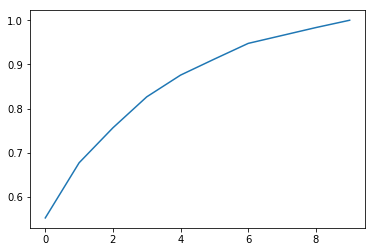

In [9]:
import matplotlib.pyplot as plt
res = np.array(res)
count = 0
rerank = []
for j in range(1,11):
    count = 0
    for i in range(len(res[0])):
        if 0 in res[:,i].reshape(10).argsort()[-j:]:
            count+=1
    rerank.append(count/(1*10000))
print(rerank)
plt.plot(rerank)
plt.show()